Datos cargados desde 'datos_spam.csv'
Atributos: ['palabra_free', 'palabra_offer', 'exclamaciones', 'longitud', 'mayusculas']

=== DIVISIÓN DE DATOS ===
Train: 600 | Val: 200 | Test: 200

=== CONFIGURACIÓN MANUAL DE HIPERPARÁMETROS ===
- hidden_layer_sizes: (32, 16)
- activation: relu
- alpha: 0.0001
- learning_rate_init: 0.001
- solver: adam
- batch_size: 64
- max_iter: 500

=== PIPELINE CON HIPERPARÁMETROS MANUALES ===
Pipeline creado con las configuraciones manuales.

=== ENTRENAMIENTO DIRECTO ===
Entrenamiento completado.

--- Validación (hold-out) ---
Accuracy: 0.8600
Matriz de confusión:
 [[84 16]
 [12 88]]
Reporte de clasificación:
               precision    recall  f1-score   support

           0     0.8750    0.8400    0.8571       100
           1     0.8462    0.8800    0.8627       100

    accuracy                         0.8600       200
   macro avg     0.8606    0.8600    0.8599       200
weighted avg     0.8606    0.8600    0.8599       200


--- Test (final) ---
Acc

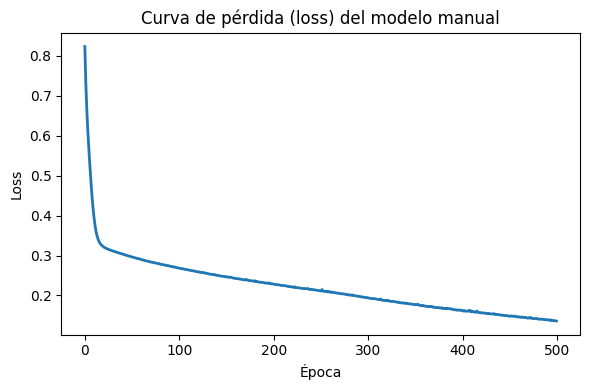

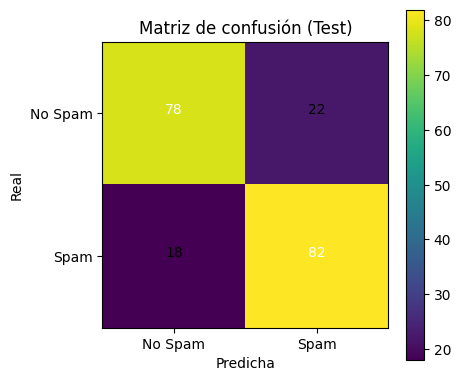

In [8]:
# ============================================================
# CLASIFICADOR SPAM vs NO SPAM (MLP - Configuración Manual) - Colab
# ------------------------------------------------------------
# Objetivo: Dado un "correo" con atributos sintéticos, predecir si es spam (1) o no spam (0).
# Incluye:
#  - Carga de datos generados (desde 'datos_spam.csv')
#  - División ajustable de datos: train / val / test
#  - Pipeline: StandardScaler + MLPClassifier
#  - Configuración manual de hiperparámetros de la MLP
#  - Entrenamiento directo (sin GridSearchCV)
#  - Métricas y gráficas: loss, matriz de confusión
# ============================================================

import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import itertools
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

# ------------------------------------------------------------
# 0) Cargar datos generados (desde 'datos_spam.csv')
# ------------------------------------------------------------
try:
    df = pd.read_csv('datos_spam.csv')
    X = df.drop('target', axis=1).values
    y = df['target'].values
    feature_names = list(df.drop('target', axis=1).columns)
    print("Datos cargados desde 'datos_spam.csv'")
    print("Atributos:", feature_names)
except FileNotFoundError:
    print("Error: 'datos_spam.csv' no encontrado. Asegúrate de ejecutar la celda anterior para generarlo.")
    # Puedes agregar aquí la lógica para generar los datos si el archivo no existe,
    # o simplemente salir/manejar el error.
    # Por ahora, asumimos que la celda anterior ya se ejecutó.


# ------------------------------------------------------------
# 1) CONFIGURACIÓN DE DIVISIONES (AJUSTABLE)
# ------------------------------------------------------------
# Proporciones para test y validación (val es DENTRO de trainval)
TEST_SIZE = 0.20     # 20% para test (ajustable)
VAL_SIZE  = 0.20     # 20% para validación (de la parte de trainval) (ajustable)
RANDOM_STATE = 42

# ------------------------------------------------------------
# 2) División del dataset: Train / Val / Test (ajustable)
# ------------------------------------------------------------
if 'X' in locals() and 'y' in locals(): # Asegurarse de que los datos se cargaron
    X_trainval, X_test, y_trainval, y_test = train_test_split(
        X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y
    )
    val_rel = VAL_SIZE / (1.0 - TEST_SIZE)  # fracción relativa dentro de trainval
    X_train, X_val, y_train, y_val = train_test_split(
        X_trainval, y_trainval, test_size=val_rel, random_state=RANDOM_STATE, stratify=y_trainval
    )

    print("\n=== DIVISIÓN DE DATOS ===")
    print(f"Train: {X_train.shape[0]} | Val: {X_val.shape[0]} | Test: {X_test.shape[0]}")

    # ------------------------------------------------------------
    # 3) Configuración Manual de Hiperparámetros de la MLP
    # ------------------------------------------------------------
    print("\n=== CONFIGURACIÓN MANUAL DE HIPERPARÁMETROS ===")

    # --- Modifica estos valores para experimentar ---

    # hidden_layer_sizes: Tupla que define el número de neuronas en cada capa oculta.
    # Ejemplo: (32,) una capa con 32 neuronas; (64, 32) dos capas con 64 y 32 neuronas.
    # Más capas/neuronas aumentan la capacidad del modelo pero también el riesgo de sobreajuste.
    MANUAL_HIDDEN_LAYER_SIZES = (32, 16)

    # activation: Función de activación para las capas ocultas. Introduce no linealidad.
    # Opciones comunes: 'relu' (Rectified Linear Unit), 'tanh' (Tangente Hiperbólica), 'logistic' (Sigmoide).
    # 'relu' suele ser una buena opción por defecto y rápida. 'tanh' puede ser útil si los datos están centrados.
    MANUAL_ACTIVATION = 'relu'

    # alpha: Regularización L2 (penalización de pesos). Ayuda a prevenir el sobreajuste.
    # Valores más altos aumentan la regularización. Un valor de 0 significa sin regularización.
    # Ejemplo de valores: 1e-5, 1e-4, 1e-3, 0.01, 0.1.
    # Si alpha es muy alto, puede causar subajuste. Si es muy bajo, puede no prevenir el sobreajuste.
    MANUAL_ALPHA = 1e-4

    # learning_rate_init: Tasa de aprendizaje inicial del optimizador.
    # Controla el tamaño de los pasos que da el optimizador para encontrar el mínimo de la función de pérdida.
    # Valores más altos (ej: 0.1) pueden hacer que el entrenamiento sea más rápido pero inestable (saltos grandes).
    # Valores más bajos (ej: 0.0001) hacen que el entrenamiento sea más lento pero más estable.
    # Ejemplo de valores: 0.001, 0.01, 0.1.
    MANUAL_LEARNING_RATE_INIT = 0.001

    # solver: Algoritmo para la optimización de pesos.
    # 'adam': Algoritmo robusto y práctico, suele funcionar bien por defecto. Requiere batch_size.
    # 'sgd': Descenso de Gradiente Estocástico. Requiere ajuste fino (momentum, learning rate schedule). Requiere batch_size.
    # 'lbfgs': Para datasets pequeños, converge rápido, no requiere tasa de aprendizaje ni batch_size (no produce loss_curve_).
    MANUAL_SOLVER = 'adam'

    # batch_size: Tamaño del mini-lote (para 'adam'/'sgd'). Número de muestras usadas en cada paso de actualización del gradiente.
    # Valores pequeños (ej: 32) introducen más ruido en el gradiente (puede ayudar a generalizar) pero el entrenamiento es más lento por época.
    # Valores grandes (ej: 128, 256) son más estables y aprovechan mejor el hardware (GPU), pero pueden quedarse atascados en mínimos locales.
    # 'auto' usa el tamaño completo del dataset.
    MANUAL_BATCH_SIZE = 64

    # max_iter: Número máximo de épocas (iteraciones sobre todo el dataset).
    # El entrenamiento se detiene antes si converge (la pérdida deja de mejorar significativamente).
    # Aumentarlo da más oportunidad al modelo para aprender, pero si es demasiado alto puede llevar a sobreajuste y tiempo de ejecución innecesario.
    MANUAL_MAX_ITER = 500


    print(f"- hidden_layer_sizes: {MANUAL_HIDDEN_LAYER_SIZES}")
    print(f"- activation: {MANUAL_ACTIVATION}")
    print(f"- alpha: {MANUAL_ALPHA}")
    print(f"- learning_rate_init: {MANUAL_LEARNING_RATE_INIT}")
    print(f"- solver: {MANUAL_SOLVER}")
    print(f"- batch_size: {MANUAL_BATCH_SIZE}")
    print(f"- max_iter: {MANUAL_MAX_ITER}")


    # ------------------------------------------------------------
    # 4) Pipeline con Hiperparámetros Manuales
    # ------------------------------------------------------------
    print("\n=== PIPELINE CON HIPERPARÁMETROS MANUALES ===")

    pipe_manual = Pipeline([
        ("scaler", StandardScaler()),
        ("mlp", MLPClassifier(random_state=RANDOM_STATE,
                              hidden_layer_sizes=MANUAL_HIDDEN_LAYER_SIZES,
                              activation=MANUAL_ACTIVATION,
                              alpha=MANUAL_ALPHA,
                              learning_rate_init=MANUAL_LEARNING_RATE_INIT,
                              solver=MANUAL_SOLVER,
                              batch_size=MANUAL_BATCH_SIZE,
                              max_iter=MANUAL_MAX_ITER))
    ])

    print("Pipeline creado con las configuraciones manuales.")

    # ------------------------------------------------------------
    # 5) Entrenamiento directo en TRAIN
    # ------------------------------------------------------------
    print("\n=== ENTRENAMIENTO DIRECTO ===")
    pipe_manual.fit(X_train, y_train)
    print("Entrenamiento completado.")

    # ------------------------------------------------------------
    # 6) Evaluación en VAL y TEST
    # ------------------------------------------------------------
    def evaluar(nombre, Xs, ys, model):
        y_pred = model.predict(Xs)
        acc = accuracy_score(ys, y_pred)
        cm = confusion_matrix(ys, y_pred)
        rep = classification_report(ys, y_pred, digits=4)
        print(f"\n--- {nombre} ---")
        print(f"Accuracy: {acc:.4f}")
        print("Matriz de confusión:\n", cm)
        print("Reporte de clasificación:\n", rep)
        return cm

    cm_val = evaluar("Validación (hold-out)", X_val, y_val, pipe_manual)
    cm_tst = evaluar("Test (final)", X_test, y_test, pipe_manual)

    # ------------------------------------------------------------
    # 7) Gráficas: Curva de pérdida y Matriz de confusión
    # ------------------------------------------------------------
    def plot_confusion_matrix(cm, classes=("No Spam","Spam"), title="Matriz de confusión"):
        plt.figure(figsize=(4.8,4.2))
        plt.imshow(cm, interpolation="nearest")
        plt.title(title)
        plt.colorbar()
        tick_marks = np.arange(len(classes))
        plt.xticks(tick_marks, classes); plt.yticks(tick_marks, classes)
        thresh = cm.max() / 2.0
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, format(cm[i, j], 'd'),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        plt.ylabel('Real'); plt.xlabel('Predicha')
        plt.tight_layout(); plt.show()

    # Curva de pérdida (si el solver la guarda)
    mlp_manual = pipe_manual.named_steps["mlp"]
    if hasattr(mlp_manual, "loss_curve_"):
        plt.figure(figsize=(6,4))
        plt.plot(mlp_manual.loss_curve_, linewidth=2)
        plt.title("Curva de pérdida (loss) del modelo manual")
        plt.xlabel("Época"); plt.ylabel("Loss")
        plt.tight_layout(); plt.show()
    else:
        print("\nNota: El solver seleccionado no produce 'loss_curve_' (p.ej., lbfgs).")

    # Matriz de confusión en TEST
    plot_confusion_matrix(cm_tst, classes=("No Spam","Spam"), title="Matriz de confusión (Test)")

else:
    print("\nNo se pudieron cargar los datos. Ejecuta la celda anterior primero.")

=== EJEMPLOS DE DATOS ===
Atributos: ['palabra_free', 'palabra_offer', 'exclamaciones', 'longitud', 'mayusculas']
X[0] = [  4.           3.           1.         133.00467014   0.3433071 ]  -> y[0] = 1
Salida: 1=spam, 0=no spam

Datos generados guardados en 'datos_spam.csv'

=== DIVISIÓN DE DATOS ===
Train: 600 | Val: 200 | Test: 200

=== CONFIGURACIÓN DE HIPERPARÁMETROS ===

--- Explicación de Hiperparámetros ---
- mlp__hidden_layer_sizes:
  Tamaño de las capas ocultas (capacidad del modelo).
  * (16,): Una capa oculta con 16 neuronas. Menor capacidad, menos riesgo de sobreajuste.
  * (32, 16): Dos capas ocultas (32 y 16 neuronas). Mayor capacidad para patrones complejos.
  * (64, 32): Dos capas ocultas más grandes. Aún mayor capacidad, pero mayor riesgo de sobreajuste y costo computacional.
- mlp__activation:
  Función de activación en capas ocultas (introduce no linealidad).
  * 'relu': Rectified Linear Unit. Rápida y robusta, común en la mayoría de los casos.
  * 'tanh': Tangente hi

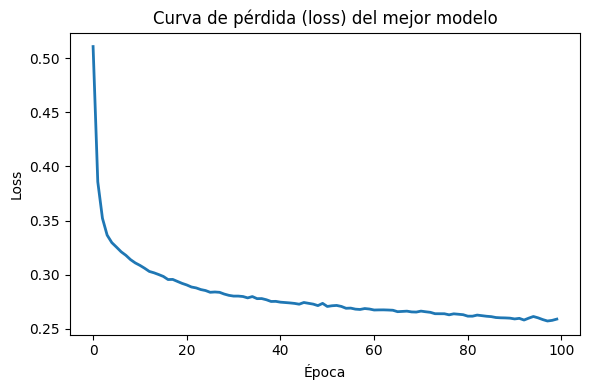

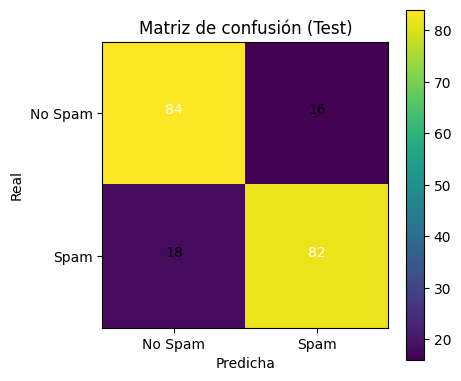


=== VISUALIZACIÓN DE LA ARQUITECTURA DE LA RED ===


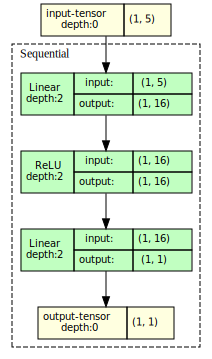


=== RESUMEN PARA LA CLASE ===
* Problema: Clasificación binaria de correos (spam=1, no spam=0).
* Entradas (X): ['palabra_free', 'palabra_offer', 'exclamaciones', 'longitud', 'mayusculas']
* Salida (y): etiqueta binaria.
* División: Train -> para aprender; Val -> para seleccionar hiperparámetros sin tocar Test; Test -> estimación imparcial del desempeño final.
* Efecto típico de hiperparámetros:
  - hidden_layer_sizes: ↑capacidad => +riesgo overfitting; ↓capacidad => subajuste.
  - activation: 'relu' rápida/robusta; 'tanh' puede ser útil con datos centrados.
  - alpha (L2): ↑alpha => regulariza más (suaviza), evita overfitting; demasiado grande => subajuste.
  - learning_rate_init: ↑ => aprende rápido pero puede inestabilizar; ↓ => estable pero lento.
  - solver: 'adam' suele funcionar bien sin mucho ajuste; 'sgd' requiere tuning (momentum/schedule).
  - batch_size: mini-lotes pequeños añaden ruido (a veces mejor generalización); grandes son más estables.


In [9]:
# ============================================================
# CLASIFICADOR SPAM vs NO SPAM (MLP + GridSearchCV) - Colab
# ------------------------------------------------------------
# Objetivo: Dado un "correo" con atributos sintéticos, predecir si es spam (1) o no spam (0).
# Incluye:
#  - Generación de dataset sintético (1000 correos, 5 atributos) y guardado a CSV (más difícil de clasificar)
#  - División ajustable de datos: train / val / test
#  - Pipeline: StandardScaler + MLPClassifier
#  - Ajuste de hiperparámetros con GridSearchCV (CV estratificada)
#  - Configuración y explicación de hiperparámetros (en el código)
#  - Métricas y gráficas: loss, matriz de confusión
#  - Visualización de la arquitectura de la red (ejemplo con PyTorch)
# ============================================================

import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import itertools
import warnings
import pandas as pd
import torch # Importar PyTorch para visualización
import torch.nn as nn # Importar módulo de red neuronal de PyTorch
from torchview import draw_graph # Importar para visualizar la arquitectura
# from ipywidgets import interact, Dropdown, IntText, VBox, Label # Importar para widgets interactivos
from IPython.display import display # Importar para mostrar widgets

warnings.filterwarnings("ignore")

# ------------------------------------------------------------
# 0) CONFIGURACIÓN DE DIVISIONES (AJUSTABLE)
# ------------------------------------------------------------
# Proporciones para test y validación (val es DENTRO de trainval)
TEST_SIZE = 0.20     # 20% para test (ajustable)
VAL_SIZE  = 0.20     # 20% para validación (de la parte de trainval) (ajustable)
RANDOM_STATE = 42

# ------------------------------------------------------------
# 1) Generación de la base de datos sintética (1000 correos) - MÁS DIFÍCIL
# ------------------------------------------------------------
# Atributos:
# - palabra_free: frecuencia de "free"
# - palabra_offer: frecuencia de "offer"
# - exclamaciones: número de "!"
# - longitud: longitud del correo (número de palabras)
# - mayusculas: proporción de texto en MAYÚSCULAS
#
# SALIDA:
# - 0 = no spam
# - 1 = spam
np.random.seed(RANDOM_STATE)
n_samples = 1000

# Ajustar parámetros para mayor solapamiento y dificultad
spam = np.column_stack([
    np.random.poisson(2, n_samples//2),        # free (menos distinción)
    np.random.poisson(3, n_samples//2),        # offer (menos distinción)
    np.random.poisson(3, n_samples//2),        # exclamaciones (menos distinción)
    np.random.normal(150, 30, n_samples//2),   # longitud (más cercanos)
    np.random.uniform(0.2, 0.8, n_samples//2)  # mayúsculas (más solapamiento)
])
y_spam = np.ones(n_samples//2)

no_spam = np.column_stack([
    np.random.poisson(1, n_samples//2),
    np.random.poisson(2, n_samples//2),
    np.random.poisson(2, n_samples//2),
    np.random.normal(180, 30, n_samples//2),   # longitud (más cercanos)
    np.random.uniform(0.1, 0.5, n_samples//2)  # mayúsculas (más solapamiento)
])
y_no_spam = np.zeros(n_samples//2)

X = np.vstack([spam, no_spam]).astype(float)
y = np.hstack([y_spam, y_no_spam]).astype(int)
feature_names = ["palabra_free", "palabra_offer", "exclamaciones", "longitud", "mayusculas"]

print("=== EJEMPLOS DE DATOS ===")
print("Atributos:", feature_names)
print("X[0] =", X[0], " -> y[0] =", y[0])
print("Salida: 1=spam, 0=no spam")

# Guardar los datos generados en un archivo CSV
df = pd.DataFrame(X, columns=feature_names)
df['target'] = y
df.to_csv('datos_spam.csv', index=False)
print("\nDatos generados guardados en 'datos_spam.csv'")


# ------------------------------------------------------------
# 2) División del dataset: Train / Val / Test (ajustable)
# ------------------------------------------------------------
X_trainval, X_test, y_trainval, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y
)
val_rel = VAL_SIZE / (1.0 - TEST_SIZE)  # fracción relativa dentro de trainval
X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval, test_size=val_rel, random_state=RANDOM_STATE, stratify=y_trainval
)

print("\n=== DIVISIÓN DE DATOS ===")
print(f"Train: {X_train.shape[0]} | Val: {X_val.shape[0]} | Test: {X_test.shape[0]}")


# ------------------------------------------------------------
# 3) Configuración y espacio de hiperparámetros (EN EL CÓDIGO)
# ------------------------------------------------------------
print("\n=== CONFIGURACIÓN DE HIPERPARÁMETROS ===")

# Pipeline: escalado + MLP
pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("mlp", MLPClassifier(random_state=RANDOM_STATE, max_iter=100)) # Aumentar max_iter por si acaso
])

# Espacio de búsqueda para GridSearchCV
param_grid = {
    "mlp__hidden_layer_sizes": [(16,), (32, 16), (64, 32)],
    "mlp__activation": ["relu", "tanh"],
    "mlp__alpha": [1e-5, 1e-4, 1e-3],
    "mlp__learning_rate_init": [0.001, 0.01],
    "mlp__solver": ["adam"],
    "mlp__batch_size": [32, 64, 128]
}

# EXPLICACIÓN de hiperparámetros (en el código)
print("\n--- Explicación de Hiperparámetros ---")
print("- mlp__hidden_layer_sizes:")
print("  Tamaño de las capas ocultas (capacidad del modelo).")
print("  * (16,): Una capa oculta con 16 neuronas. Menor capacidad, menos riesgo de sobreajuste.")
print("  * (32, 16): Dos capas ocultas (32 y 16 neuronas). Mayor capacidad para patrones complejos.")
print("  * (64, 32): Dos capas ocultas más grandes. Aún mayor capacidad, pero mayor riesgo de sobreajuste y costo computacional.")
print("- mlp__activation:")
print("  Función de activación en capas ocultas (introduce no linealidad).")
print("  * 'relu': Rectified Linear Unit. Rápida y robusta, común en la mayoría de los casos.")
print("  * 'tanh': Tangente hiperbólica. Útil si los datos están centrados alrededor de 0.")
print("  * 'logistic' (sigmoide): Comprime la salida entre 0 y 1. Puede sufrir de gradientes desvanecidos.")
print("- mlp__alpha:")
print("  Regularización L2. Penaliza pesos grandes para evitar sobreajuste (modelo más suave).")
print("  * Valores más altos: Mayor regularización, reduce sobreajuste, pero puede causar subajuste si es demasiado grande.")
print("- mlp__learning_rate_init:")
print("  Tasa de aprendizaje inicial del optimizador.")
print("  * Más alta: Aprende más rápido pero puede volverse inestable (saltos grandes en el espacio de pesos).")
print("  * Más baja: Más estable, pero el entrenamiento puede ser muy lento.")
print("- mlp__solver:")
print("  Algoritmo de optimización para actualizar pesos.")
print("  * 'adam': Algoritmo robusto y práctico, suele funcionar bien sin mucho ajuste.")
print("  * 'sgd': Descenso de gradiente estocástico. Requiere más ajuste fino (momentum, schedule de tasa de aprendizaje).")
print("  * 'lbfgs': Para datasets pequeños, converge rápido, no requiere tasa de aprendizaje (sin curvas por época).")
print("- mlp__batch_size:")
print("  Tamaño de mini-lote para 'adam'/'sgd'. Número de muestras usadas en cada paso de actualización del gradiente.")
print("  * Pequeños: Introducen ruido (a veces mejora generalización), más lentos por época.")
print("  * Grandes: Más estables, aprovechamiento más eficiente del hardware (GPU), pero pueden quedarse atascados en mínimos locales.")


# ------------------------------------------------------------
# 4) Búsqueda por CV (en TRAIN) y selección del mejor modelo
# ------------------------------------------------------------
print("\n=== BÚSQUEDA POR CV Y SELECCIÓN DEL MEJOR MODELO ===")
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
gs = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    scoring="accuracy",
    cv=cv,
    n_jobs=-1,
    refit=True,   # reentrena en todo TRAIN con el mejor set
    verbose=0
)

gs.fit(X_train, y_train)

print("\n=== MEJORES PARÁMETROS (CV en TRAIN) ===")
print(gs.best_params_)
print(f"Mejor accuracy CV (promedio 5-fold): {gs.best_score_:.4f}")

best_model = gs.best_estimator_  # Pipeline ya reentrenado en todo TRAIN con los mejores hiperparámetros

# ------------------------------------------------------------
# 5) Evaluación en VAL y TEST
# ------------------------------------------------------------
def evaluar(nombre, Xs, ys, model):
    y_pred = model.predict(Xs)
    acc = accuracy_score(ys, y_pred)
    cm = confusion_matrix(ys, y_pred)
    rep = classification_report(ys, y_pred, digits=4)
    print(f"\n--- {nombre} ---")
    print(f"Accuracy: {acc:.4f}")
    print("Matriz de confusión:\n", cm)
    print("Reporte de clasificación:\n", rep)
    return cm

cm_val = evaluar("Validación (hold-out)", X_val, y_val, best_model)
cm_tst = evaluar("Test (final)", X_test, y_test, best_model)

# ------------------------------------------------------------
# 6) Gráficas: Curva de pérdida y Matriz de confusión
# ------------------------------------------------------------
def plot_confusion_matrix(cm, classes=("No Spam","Spam"), title="Matriz de confusión"):
    plt.figure(figsize=(4.8,4.2))
    plt.imshow(cm, interpolation="nearest")
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes); plt.yticks(tick_marks, classes)
    thresh = cm.max() / 2.0
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('Real'); plt.xlabel('Predicha')
    plt.tight_layout(); plt.show()

# Curva de pérdida (si el solver la guarda)
mlp_best = best_model.named_steps["mlp"]
if hasattr(mlp_best, "loss_curve_"):
    plt.figure(figsize=(6,4))
    plt.plot(mlp_best.loss_curve_, linewidth=2)
    plt.title("Curva de pérdida (loss) del mejor modelo")
    plt.xlabel("Época"); plt.ylabel("Loss")
    plt.tight_layout(); plt.show()
else:
    print("Nota: El solver seleccionado no produce 'loss_curve_' (p.ej., lbfgs).")

# Matriz de confusión en TEST
plot_confusion_matrix(cm_tst, classes=("No Spam","Spam"), title="Matriz de confusión (Test)")

# ------------------------------------------------------------
# 7) Visualización de la arquitectura de la red (ejemplo con PyTorch)
# ------------------------------------------------------------
print("\n=== VISUALIZACIÓN DE LA ARQUITECTURA DE LA RED ===")

# Definir un modelo MLP simple usando PyTorch para visualización
class SimpleMLP(nn.Module):
    def __init__(self, input_size, hidden_layers, output_size, activation='relu'):
        super(SimpleMLP, self).__init__()
        layers = []
        current_size = input_size
        for hidden_size in hidden_layers:
            layers.append(nn.Linear(current_size, hidden_size))
            if activation == 'relu':
                layers.append(nn.ReLU())
            elif activation == 'tanh':
                layers.append(nn.Tanh())
            elif activation == 'logistic':
                 layers.append(nn.Sigmoid())
            current_size = hidden_size
        layers.append(nn.Linear(current_size, output_size))
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

# Visualizar la arquitectura de la red neuronal usando los mejores hiperparámetros encontrados
# Nota: Esto visualiza la arquitectura del MEJOR modelo encontrado por GridSearchCV
input_size = len(feature_names)
output_size = 1 # Para clasificación binaria (0 o 1)

best_hidden_layers = gs.best_params_['mlp__hidden_layer_sizes']
best_activation = gs.best_params_['mlp__activation']

dummy_input = torch.randn(1, input_size)
model_viz = SimpleMLP(input_size, best_hidden_layers, output_size, activation=best_activation)

model_graph = draw_graph(model_viz, input_data=dummy_input, expand_nested=True)
display(model_graph.visual_graph)


# ------------------------------------------------------------
# 8) Resumen explícito para la clase
# ------------------------------------------------------------
print("\n=== RESUMEN PARA LA CLASE ===")
print("* Problema: Clasificación binaria de correos (spam=1, no spam=0).")
print("* Entradas (X):", feature_names)
print("* Salida (y): etiqueta binaria.")
print("* División: Train -> para aprender; Val -> para seleccionar hiperparámetros "
      "sin tocar Test; Test -> estimación imparcial del desempeño final.")
print("* Efecto típico de hiperparámetros:")
print("  - hidden_layer_sizes: ↑capacidad => +riesgo overfitting; ↓capacidad => subajuste.")
print("  - activation: 'relu' rápida/robusta; 'tanh' puede ser útil con datos centrados.")
print("  - alpha (L2): ↑alpha => regulariza más (suaviza), evita overfitting; demasiado grande => subajuste.")
print("  - learning_rate_init: ↑ => aprende rápido pero puede inestabilizar; ↓ => estable pero lento.")
print("  - solver: 'adam' suele funcionar bien sin mucho ajuste; 'sgd' requiere tuning (momentum/schedule).")
print("  - batch_size: mini-lotes pequeños añaden ruido (a veces mejor generalización); grandes son más estables.")